# Common cell for all questions

In [29]:
# importing all packages
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
from PIL import Image 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
import math
from tensorflow.keras import initializers
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

In [30]:
# wandb config
!pip install wandb
import wandb
!wandb login

wandb: Currently logged in as: cs20s002 (use `wandb login --relogin` to force relogin)


In [31]:
# Loading dataset
df = fashion_mnist.load_data()
((train_X, train_Y), (test_X, test_Y)) = df

# Question 1


In [28]:
# Extracting unique images classwise 
unique_class_values, unique_class_values_indices = np.unique(train_Y, return_index=True)
unique_sample_images = train_X[unique_class_values_indices]
image_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [ ]:
# Wandb config for question 1

# Intialize a new run
wandb.init(project="DL_assignment_1", name="Question_1_images")

# Log the image
wandb.log({"Examples": [ wandb.Image( plt.imshow( im, cmap="Greys"), caption = label  ) for im,label in zip(unique_sample_images,image_labels )  ]})

wandb.finish()

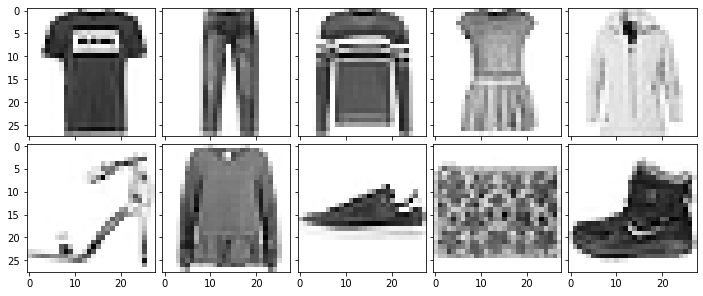

In [29]:
# plotting unique images
fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, unique_sample_images ):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap = 'Greys')

plt.show()

# Question 2, 3, 4, 5, 6

In [6]:
# Mini-Batch Gradient Descent with cross entropy loss and wandb log 
random.seed(0)

class Layer:

    def __init__(self, num_inputs, num_nuerons, activation, intilization):
        
        if intilization == "random":
            
            self.activation = activation

            self.weights = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-0.5,0.5,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias_nag = (np.random.uniform(-0.5,0.5,(num_nuerons)))


            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

        if intilization == "Xavier":

            self.activation = activation

            limit = np.sqrt(6/ (num_nuerons + num_inputs) )

            self.weights = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-limit,limit,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )/1
            self.bias_nag = (np.random.uniform(-limit,limit,(num_nuerons)))/1

            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

class Nueral_net:
  
    def __init__(self,):
        self.layers = []
        self.outputs = None
        self.loss_list = []

    def add_layer(self,layer):
        self.layers.append(layer)

    def fit(self, X, Y, validate_X, validate_Y, epochs, eta, mini_batch_size, optimizer, gamma, epsilon, beta1, beta2, alpha):
        
        # iterating over epochs
        for epoch in range(epochs):
            
            # input_X shape = ( number_of_features, number_of_examples)
            input_X = X 
            # input_Y shape = ( number_of_examples, )
            input_Y = Y

            mini_batch_size = mini_batch_size
            no_of_batches = X.shape[1] / mini_batch_size

            # iterating over batches
            for batch in range(int(no_of_batches)):
                
                mini_batch_X = X [ : , mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                mini_batch_Y = Y [  mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                
                mini_batch_input = mini_batch_X


                # forward propogation                
                for layer in self.layers: 
          
                    layer.aL = self.apply_linear_sum(layer.weights, layer.bias, mini_batch_X )
                    
                    layer.hL = self.apply_activation_function( layer.aL, layer.activation ) 
                    
                    mini_batch_X = layer.hL

                mini_batch_y_bar = mini_batch_X
                
                # m = number of examples in batch 
                m = mini_batch_y_bar.shape[1]

                # loss function with cross entropy
                L = (np.sum( -np.log(mini_batch_y_bar.T[ np.arange(mini_batch_y_bar.shape[1]) , mini_batch_Y ] ) ) / m)
                self.loss_list.append(L)
    
                
                # back propogation

                # creating one hot vector for every examples
                # shape of one hot vector = (number of examples, number of output units)
                one_hot_vector = np.zeros(mini_batch_y_bar.T.shape)
                rows = np.arange(mini_batch_y_bar.shape[1])
                one_hot_vector[rows,mini_batch_Y] = 1
            
                # gradients for the output layer 
                dL_aL = ( - np.subtract(one_hot_vector.T , mini_batch_y_bar) )
        
                # gradients for the hidden layer
                for layer in list(range(1,len(self.layers)))[::-1] :

                    # gradients with respect to parameters
                    self.layers[layer].weights_grad = np.dot( dL_aL , self.layers[layer-1].hL.T ) / m
                    self.layers[layer].bias_grad = np.sum(dL_aL, axis=1)/m
                    
                    # gradients with respect to layer below
                    dL_hL_minus_1 = np.dot(self.layers[layer].weights.T, dL_aL)
                    dL_aL = np.multiply(dL_hL_minus_1 , self.apply_activation_function_derivative( self.layers[layer-1].aL, self.layers[layer-1].hL, self.layers[layer-1].activation, m ))
                    
                # gradients of 1st layer
                self.layers[0].weights_grad = np.dot( dL_aL , mini_batch_input.T )/m
                self.layers[0].bias_grad = np.sum(dL_aL, axis=1)/m

                # update weights
                self.update_parameters(eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch)
                # applying regularization
                self.apply_reg(eta, alpha)

            wandb.log( { "epoch" : epoch } )
            wandb.log( { "training loss" : self.cal_loss(input_X, input_Y) } )
            wandb.log( { "validation loss" : self.cal_loss(validate_X, validate_Y) } )
            wandb.log( { "training accuracy" : self.accuracy(input_X, input_Y) } )
            wandb.log( { "validation accuracy" : self.accuracy(validate_X, validate_Y) } )
            
    def apply_reg(self, eta, alpha):

        for layer in self.layers:
            
            layer.weights = np.subtract( layer.weights, (eta*alpha)*layer.weights )
            layer.bias = np.subtract( layer.bias, (eta*alpha)*layer.bias )
        
    def cal_loss(self, X , Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = X

        L = (np.sum( -np.log(y_bar.T[ np.arange(y_bar.shape[1]) , Y ] ) ) / Y.shape[0] )
        
        return L
    
    def update_parameters(self, eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch):
        
        if optimizer == "momentum":

            for layer in self.layers:
                
                moment_update_weights = np.add( gamma*layer.prev_update_weights , eta*layer.weights_grad) 
                moment_update_bias = np.add( gamma*layer.prev_update_bias , eta*layer.bias_grad )

                layer.weights = np.subtract( layer.weights, moment_update_weights )
                layer.bias = np.subtract( layer.bias, moment_update_bias )

                layer.prev_update_weights = moment_update_weights
                layer.prev_update_bias = moment_update_bias
        
        if optimizer == "nesterov":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add(gamma*layer.prev_update_weights , eta*layer.weights_grad)
                layer.prev_update_bias = np.add(gamma*layer.prev_update_bias , eta*layer.bias_grad)

                layer.weights_nag = np.subtract(layer.weights_nag , layer.prev_update_weights )
                layer.bias_nag = np.subtract(layer.bias_nag , layer.prev_update_bias )
                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , gamma*layer.prev_update_weights )
                layer.bias = np.subtract(layer.bias_nag , gamma*layer.prev_update_bias )

            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag
                
        if optimizer == "AdaGrad":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add(layer.self.prev_update_weights_grad_square, (layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add(layer.self.prev_update_bias_grad_square, (layer.bias_grad)**2 ) 

                layer.weights = np.subtract(layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract(layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer== "rmsprop":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 
 
                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer == "adam":

            for layer in self.layers:
                
                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)
                
        if optimizer == "nadam":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1 )*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights_nag = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias_nag = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)

                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , beta1*prev_update_weights_normalize)
                layer.bias = np.subtract(layer.bias_nag , beta1*prev_update_bias_normalize)
                
            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag

        if optimizer == "sgd":
                
            for layer in self.layers:

                layer.weights = np.subtract(layer.weights , eta*layer.weights_grad)
                layer.bias = np.subtract(layer.bias , eta*layer.bias_grad )
                
    def accuracy(self, X, Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = np.argmax( X ,axis = 0)

        return ( np.sum( Y == y_bar )/y_bar.shape[0])*100

    def apply_linear_sum( self, weights, bias, X ):
        linear_sum = np.dot( weights, X ) + bias.reshape( bias.shape[0], 1 )
        return linear_sum

    def apply_activation_function( self, linear_sum, activation_fun ):
        
        if activation_fun == "relu":
            linear_sum = np.where( linear_sum > 0 , linear_sum, linear_sum*0.01 )
            return linear_sum
        
        if activation_fun == "sigmoid":
            return (1 / (1 + np.exp( - linear_sum) ) )
        
        if activation_fun == "softmax":
            return (np.exp(linear_sum) / np.sum(np.exp(linear_sum), axis=0))
        
        if activation_fun == "tanh":
            return ( (np.exp( linear_sum) - np.exp( - linear_sum) ) / (np.exp( linear_sum) + np.exp( - linear_sum) ) )

    def apply_activation_function_derivative( self, aL, hL, activation_fun, m ):
        
        if activation_fun == "relu":
            aL = np.where(aL >= 0, 1, 0.01) 
            return aL
            
        if activation_fun == "sigmoid":
            return np.multiply(hL, (1-hL))
        
        if activation_fun == "tanh":
            return (1 - (hL)**2)



In [7]:
# sweep config
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'accuracy',
        'goal' : 'maximize'
    },
    'parameters' : {
        'epochs' : {
            'values' : [5, 10]
        },
        'hidden_layers' : {
            'values' : [3, 4, 5]
        },
        'num_nuerons' : {
            'values' : [32, 64, 128]
        },
        'alpha' : {
            'values' : [0, 0.0005, 0.5]
        },
        'eta' : {
            'values' : [1e-3, 1e-4]
        },
        'optimizer' : {
            'values' : ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]
        },
        'batch_size' : {
            'values' : [16, 32, 64]
        },
        'intialisation' : {
            'values' : ["random", "Xavier"]
        },
        'activation' : {
            'values' : ["sigmoid", "tanh", "relu"]
        }
    }
}


In [12]:
sweep_id = wandb.sweep(sweep_config,  entity = "cs20s002", project = "DL_assignment_1")

Create sweep with ID: f3aad59d
Sweep URL: https://wandb.ai/cs20s002/DL_assignment_1/sweeps/f3aad59d


In [1]:
def train():

    config_defaults = {
        'epochs' : 5,
        'hidden_layers' : 3,
        'num_nuerons' : 128,
        'alpha' : 0.0005, 
        'eta' : 1e-3,
        'optimizer' : "adam",
        'batch_size' : 128,
        'intialisation' : "random",
        'activation' : "relu",
        'beta1' : 0.9,
        'beta2' : 0.999,
        'gamma' : 0.9,
        'epsilon': 1e-8,
    }

    # wandb intialisation
    wandb.init(config = config_defaults, project="DL_assignment_1" )
    
    config = wandb.config
    
    exp_name = "hl_" + str(config.hidden_layers) + "_nn_"+ str(config.num_nuerons) +  "_ac_" + str(config.activation) + "_op_" + str(config.optimizer) + "_bs_" + str(config.batch_size) 
    
    wandb.run.name = exp_name

    num_pixels = train_X.shape[1]*train_X.shape[2]

    model = Nueral_net()

    # intializing first hidden layer
    model.add_layer( Layer ( num_inputs = train_X.shape[1]*train_X.shape[2] , num_nuerons = config.num_nuerons , activation = config.activation ,intilization = config.intialisation) )

    # intializing all remaining hidden layer
    for h in range(config.hidden_layers - 1):
        model.add_layer( Layer ( num_inputs = config.num_nuerons , num_nuerons = config.num_nuerons, activation = config.activation, intilization = config.intialisation) )

    # intializing output layer
    model.add_layer( Layer ( num_inputs = config.num_nuerons, num_nuerons = 10 , activation = "softmax",intilization = config.intialisation) )

    # input data
    X = ((train_X.reshape( train_X.shape[0],-1).T)[:,:50000])*(1.0/255)
    Y = train_Y[:50000]
    
    # validation data
    validate_X = ((train_X.reshape( train_X.shape[0],-1).T)[:,50000:])*(1.0/255)
    validate_Y = train_Y[50000:]
    
    model.fit( X, Y, validate_X, validate_Y, epochs = config.epochs, eta = config.eta, mini_batch_size = config.batch_size , optimizer = config.optimizer, gamma = config.gamma, epsilon = config.epsilon , beta1 = config.beta1, beta2 = config.beta2, alpha = config.alpha)

    train_acc = model.accuracy( X, Y)
    wandb.log( { "accuracy" : train_acc } )
    
    # test data
    tst_X = (test_X.reshape( test_X.shape[0],-1).T)*(1.0/255)
    tst_Y = test_Y

    test_acc = model.accuracy( tst_X, tst_Y)
    wandb.log( { "test accuracy" : test_acc } )

In [ ]:
wandb.agent(sweep_id, train, count = 50)

wandb: Agent Starting Run: 8ge43vt6 with config:
wandb: 	activation: relu
wandb: 	alpha: 0
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	eta: 0.0001
wandb: 	hidden_layers: 5
wandb: 	intialisation: Xavier
wandb: 	num_nuerons: 64
wandb: 	optimizer: nesterov
wandb: WARNING Ignored wandb.init() arg project when running a sweep


# Question 7

In [4]:
# Mini-Batch Gradient Descent with cross entropy loss for local run
random.seed(0)

class Layer:

    def __init__(self, num_inputs, num_nuerons, activation, intilization):
        
        if intilization == "random":
            
            self.activation = activation

            self.weights = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-0.5,0.5,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias_nag = (np.random.uniform(-0.5,0.5,(num_nuerons)))


            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

        if intilization == "Xavier":

            self.activation = activation

            limit = np.sqrt(6/ (num_nuerons + num_inputs) )

            self.weights = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-limit,limit,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )/1
            self.bias_nag = (np.random.uniform(-limit,limit,(num_nuerons)))/1

            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

class Nueral_net:
  
    def __init__(self,):
        self.layers = []
        self.outputs = None
        self.loss_list = []

    def add_layer(self,layer):
        self.layers.append(layer)

    def fit(self, X, Y, validate_X, validate_Y, epochs, eta, mini_batch_size, optimizer, gamma, epsilon, beta1, beta2, alpha):
        
        # iterating over epochs
        for epoch in range(epochs):
            
            # input_X shape = ( number_of_features, number_of_examples)
            input_X = X 
            # input_Y shape = ( number_of_examples, )
            input_Y = Y

            mini_batch_size = mini_batch_size
            no_of_batches = X.shape[1] / mini_batch_size

            # iterating over batches
            for batch in range(int(no_of_batches)):
                
                mini_batch_X = X [ : , mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                mini_batch_Y = Y [  mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                
                mini_batch_input = mini_batch_X


                # forward propogation                
                for layer in self.layers: 
          
                    layer.aL = self.apply_linear_sum(layer.weights, layer.bias, mini_batch_X )
                    
                    layer.hL = self.apply_activation_function( layer.aL, layer.activation ) 
                    
                    mini_batch_X = layer.hL

                mini_batch_y_bar = mini_batch_X
                
                # m = number of examples in batch 
                m = mini_batch_y_bar.shape[1]

                # loss function with cross entropy
                L = (np.sum( -np.log(mini_batch_y_bar.T[ np.arange(mini_batch_y_bar.shape[1]) , mini_batch_Y ] ) ) / m)
                self.loss_list.append(L)
    
                
                # back propogation

                # creating one hot vector for every examples
                # shape of one hot vector = (number of examples, number of output units)
                one_hot_vector = np.zeros(mini_batch_y_bar.T.shape)
                rows = np.arange(mini_batch_y_bar.shape[1])
                one_hot_vector[rows,mini_batch_Y] = 1
            
                # gradients for the output layer 
                dL_aL = ( - np.subtract(one_hot_vector.T , mini_batch_y_bar) )
        
                # gradients for the hidden layer
                for layer in list(range(1,len(self.layers)))[::-1] :

                    # gradients with respect to parameters
                    self.layers[layer].weights_grad = np.dot( dL_aL , self.layers[layer-1].hL.T ) / m
                    self.layers[layer].bias_grad = np.sum(dL_aL, axis=1)/m
                    
                    # gradients with respect to layer below
                    dL_hL_minus_1 = np.dot(self.layers[layer].weights.T, dL_aL)
                    dL_aL = np.multiply(dL_hL_minus_1 , self.apply_activation_function_derivative( self.layers[layer-1].aL, self.layers[layer-1].hL, self.layers[layer-1].activation, m ))
                    
                # gradients of 1st layer
                self.layers[0].weights_grad = np.dot( dL_aL , mini_batch_input.T )/m
                self.layers[0].bias_grad = np.sum(dL_aL, axis=1)/m

                # update weights
                self.update_parameters(eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch)
                # applying regularization
                self.apply_reg(eta, alpha)
            
    def apply_reg(self, eta, alpha):

        for layer in self.layers:
            
            layer.weights = np.subtract( layer.weights, (eta*alpha)*layer.weights )
            layer.bias = np.subtract( layer.bias, (eta*alpha)*layer.bias )
        
    def cal_loss(self, X , Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = X

        L = (np.sum( -np.log(y_bar.T[ np.arange(y_bar.shape[1]) , Y ] ) ) / Y.shape[0] )
        
        return L
    
    def update_parameters(self, eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch):
        
        if optimizer == "momentum":

            for layer in self.layers:
                
                moment_update_weights = np.add( gamma*layer.prev_update_weights , eta*layer.weights_grad) 
                moment_update_bias = np.add( gamma*layer.prev_update_bias , eta*layer.bias_grad )

                layer.weights = np.subtract( layer.weights, moment_update_weights )
                layer.bias = np.subtract( layer.bias, moment_update_bias )

                layer.prev_update_weights = moment_update_weights
                layer.prev_update_bias = moment_update_bias
        
        if optimizer == "nesterov":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add(gamma*layer.prev_update_weights , eta*layer.weights_grad)
                layer.prev_update_bias = np.add(gamma*layer.prev_update_bias , eta*layer.bias_grad)

                layer.weights_nag = np.subtract(layer.weights_nag , layer.prev_update_weights )
                layer.bias_nag = np.subtract(layer.bias_nag , layer.prev_update_bias )
                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , gamma*layer.prev_update_weights )
                layer.bias = np.subtract(layer.bias_nag , gamma*layer.prev_update_bias )

            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag
                
        if optimizer == "AdaGrad":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add(layer.self.prev_update_weights_grad_square, (layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add(layer.self.prev_update_bias_grad_square, (layer.bias_grad)**2 ) 

                layer.weights = np.subtract(layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract(layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer== "rmsprop":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 
 
                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer == "adam":

            for layer in self.layers:
                
                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)
                
        if optimizer == "nadam":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1 )*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights_nag = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias_nag = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)

                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , beta1*prev_update_weights_normalize)
                layer.bias = np.subtract(layer.bias_nag , beta1*prev_update_bias_normalize)
                
            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag

        if optimizer == "sgd":
                
            for layer in self.layers:

                layer.weights = np.subtract(layer.weights , eta*layer.weights_grad)
                layer.bias = np.subtract(layer.bias , eta*layer.bias_grad )
                
    def accuracy(self, X, Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = np.argmax( X ,axis = 0)

        return ( np.sum( Y == y_bar )/y_bar.shape[0])*100

    def apply_linear_sum( self, weights, bias, X ):
        linear_sum = np.dot( weights, X ) + bias.reshape( bias.shape[0], 1 )
        return linear_sum

    def apply_activation_function( self, linear_sum, activation_fun ):
        
        if activation_fun == "relu":
            linear_sum = np.where( linear_sum > 0 , linear_sum, linear_sum*0.01 )
            return linear_sum
        
        if activation_fun == "sigmoid":
            return (1 / (1 + np.exp( - linear_sum) ) )
        
        if activation_fun == "softmax":
            return (np.exp(linear_sum) / np.sum(np.exp(linear_sum), axis=0))
        
        if activation_fun == "tanh":
            return ( (np.exp( linear_sum) - np.exp( - linear_sum) ) / (np.exp( linear_sum) + np.exp( - linear_sum) ) )

    def apply_activation_function_derivative( self, aL, hL, activation_fun, m ):
        
        if activation_fun == "relu":
            aL = np.where(aL >= 0, 1, 0.01) 
            return aL
            
        if activation_fun == "sigmoid":
            return np.multiply(hL, (1-hL))
        
        if activation_fun == "tanh":
            return (1 - (hL)**2)



In [5]:
# Local run with best tuned hyperparameter from above sweep

model = Nueral_net()

epochs = 10
hidden_layers = 3
num_nuerons = 128
alpha = 0.0005
eta = 0.0001
optimizer = "nadam"
batch_size = 32
intialisation = "random"
activation = "sigmoid"
beta1 = 0.9
beta2 = 0.999
gamma = 0.9
epsilon = 1e-8

model.add_layer( Layer ( num_inputs = train_X.shape[1]* train_X.shape[2] , num_nuerons = num_nuerons, activation = activation, intilization = intialisation) )

for h in range(hidden_layers):
    model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = num_nuerons, activation = activation,intilization = intialisation ) )

model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = 10 , activation = "softmax" ,intilization = intialisation) )


X = ((train_X.reshape( train_X.shape[0],-1).T)[:,:50000])*(1.0/255)
Y = train_Y[:50000]
 
validate_X = ((train_X.reshape( train_X.shape[0],-1).T)[:,50000:])*(1.0/255)
validate_Y = train_Y[50000:]
    
model.fit(X, Y, validate_X, validate_Y, epochs , eta, batch_size, optimizer, gamma, epsilon, beta1, beta2, alpha)

In [6]:
# test accuracy
X = test_X.reshape(test_X.shape[0],-1).T/255.

for layer in model.layers:        
  linear_sum = model.apply_linear_sum(layer.weights, layer.bias, X )
  X = model.apply_activation_function( linear_sum , layer.activation) 

y_bar = np.argmax( X ,axis = 0)
print( (np.sum( test_Y == y_bar )/y_bar.shape[0])*100  )

86.02


wandb: Currently logged in as: cs20s002 (use `wandb login --relogin` to force relogin)


_runtime,3
_timestamp,1615699245
_step,0


_runtime,▁
_timestamp,▁
_step,▁


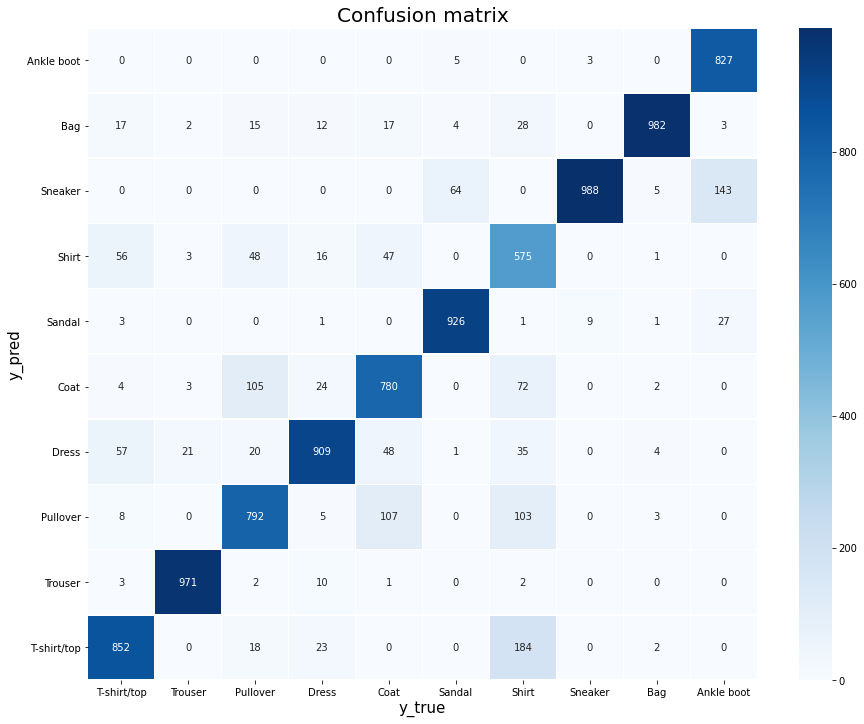

In [7]:
# plotting confusion matrix on test data
fig, ax = plt.subplots(figsize=(15, 12))
cf_matrix = confusion_matrix(y_bar, test_Y )

xticklabels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
yticklabels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
sns.heatmap( cf_matrix, annot=True,fmt = "d", linewidth = 0.5,cmap='Blues', ax = ax, xticklabels = xticklabels , yticklabels = yticklabels )

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_yticklabels(), rotation=0)

ax.invert_yaxis()

ax.set_xlabel('y_true',size=15)
ax.set_ylabel('y_pred',size=15)
ax.set_title("Confusion matrix",size = 20)


# Wandb config for question 7

# Intialize a new run
wandb.init(project="DL_assignment_1", name="Question_7_confusion_matrix")

# Log the image
wandb.log({"Confusion_matrix": [ wandb.Image( plt, caption = "Confusion_matrix"  )   ]})
# wandb.log({"Confusion_matrix": plt})

wandb.finish()

# Question 8

In [47]:
# Mini-Batch Gradient Descent with square error loss and wandb log

random.seed(0)

class Layer:

    def __init__(self, num_inputs, num_nuerons, activation, intilization):
        
        if intilization == "random":
            
            self.activation = activation

            self.weights = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-0.5,0.5,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias_nag = (np.random.uniform(-0.5,0.5,(num_nuerons)))


            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

        if intilization == "Xavier":

            self.activation = activation

            limit = np.sqrt(6/ (num_nuerons + num_inputs) )

            self.weights = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-limit,limit,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )/1
            self.bias_nag = (np.random.uniform(-limit,limit,(num_nuerons)))/1

            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

class Nueral_net:
  
    def __init__(self,):
        self.layers = []
        self.outputs = None
        self.loss_list = []

    def add_layer(self,layer):
        self.layers.append(layer)

    def fit(self, X, Y, validate_X, validate_Y, epochs, eta, mini_batch_size, optimizer, gamma, epsilon, beta1, beta2, alpha):
        
        # iterating over epochs
        for epoch in range(epochs):
            
            # input_X shape = ( number_of_features, number_of_examples)
            input_X = X 
            # input_Y shape = ( number_of_examples, )
            input_Y = Y

            mini_batch_size = mini_batch_size
            no_of_batches = X.shape[1] / mini_batch_size

            # iterating over batches
            for batch in range(int(no_of_batches)):
                
                mini_batch_X = X [ : , mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                mini_batch_Y = Y [  mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                
                mini_batch_input = mini_batch_X


                # forward propogation                
                for layer in self.layers: 
          
                    layer.aL = self.apply_linear_sum(layer.weights, layer.bias, mini_batch_X )
                    
                    layer.hL = self.apply_activation_function( layer.aL, layer.activation ) 
                    
                    mini_batch_X = layer.hL

                mini_batch_y_bar = mini_batch_X
                
                # m = number of examples in batch 
                m = mini_batch_y_bar.shape[1]


                # back propogation

                # creating one hot vector for every examples
                # shape of one hot vector = (number of examples, number of output units)
                one_hot_vector = np.zeros(mini_batch_y_bar.T.shape)
                rows = np.arange(mini_batch_y_bar.shape[1])
                one_hot_vector[rows,mini_batch_Y] = 1
            
                # loss function with square error
                L = np.sum(np.sum(np.square(np.subtract( mini_batch_y_bar, one_hot_vector.T )), axis=0 ))/m
                self.loss_list.append(L)
                
                # gradients for the output layer 
                dL_aL = np.empty(shape=(10,m) )
                for i in range(m):
                    dL_aL[:,i] = np.multiply( mini_batch_y_bar[:,i] , np.dot( (np.identity(10) - mini_batch_y_bar[:,i]).T , 2*(mini_batch_y_bar[:,i] - one_hot_vector.T[:,i]) ) )
        
                # gradients for the hidden layer
                for layer in list(range(1,len(self.layers)))[::-1] :

                    # gradients with respect to parameters
                    self.layers[layer].weights_grad = np.dot( dL_aL , self.layers[layer-1].hL.T ) / m
                    self.layers[layer].bias_grad = np.sum(dL_aL, axis=1)/m
                    
                    # gradients with respect to layer below
                    dL_hL_minus_1 = np.dot(self.layers[layer].weights.T, dL_aL)
                    dL_aL = np.multiply(dL_hL_minus_1 , self.apply_activation_function_derivative( self.layers[layer-1].aL, self.layers[layer-1].hL, self.layers[layer-1].activation, m ))
                    
                # gradients of 1st layer
                self.layers[0].weights_grad = np.dot( dL_aL , mini_batch_input.T )/m
                self.layers[0].bias_grad = np.sum(dL_aL, axis=1)/m

                # update weights
                self.update_parameters(eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch)
                # applying regularization
                self.apply_reg(eta, alpha)

            wandb.log( { "epoch" : epoch } )
            wandb.log( { "training loss" : self.cal_loss(input_X, input_Y) } )
            wandb.log( { "validation loss" : self.cal_loss(validate_X, validate_Y) } )
            wandb.log( { "training accuracy" : self.accuracy(input_X, input_Y) } )
            wandb.log( { "validation accuracy" : self.accuracy(validate_X, validate_Y) } )
            
    def apply_reg(self, eta, alpha):

        for layer in self.layers:
            
            layer.weights = np.subtract( layer.weights, (eta*alpha)*layer.weights )
            layer.bias = np.subtract( layer.bias, (eta*alpha)*layer.bias )
        
    def cal_loss(self, X , Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = X
        
        one_hot_vector = np.zeros(y_bar.T.shape)
        rows = np.arange(y_bar.shape[1])
        one_hot_vector[rows,Y] = 1
    
        # loss function with square error
        L = np.sum(np.sum(np.square(np.subtract( y_bar, one_hot_vector.T )), axis=0 )) / Y.shape[0] 
        
        return L
    
    def update_parameters(self, eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch):
        
        if optimizer == "momentum":

            for layer in self.layers:
                
                moment_update_weights = np.add( gamma*layer.prev_update_weights , eta*layer.weights_grad) 
                moment_update_bias = np.add( gamma*layer.prev_update_bias , eta*layer.bias_grad )

                layer.weights = np.subtract( layer.weights, moment_update_weights )
                layer.bias = np.subtract( layer.bias, moment_update_bias )

                layer.prev_update_weights = moment_update_weights
                layer.prev_update_bias = moment_update_bias
        
        if optimizer == "nesterov":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add(gamma*layer.prev_update_weights , eta*layer.weights_grad)
                layer.prev_update_bias = np.add(gamma*layer.prev_update_bias , eta*layer.bias_grad)

                layer.weights_nag = np.subtract(layer.weights_nag , layer.prev_update_weights )
                layer.bias_nag = np.subtract(layer.bias_nag , layer.prev_update_bias )
                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , gamma*layer.prev_update_weights )
                layer.bias = np.subtract(layer.bias_nag , gamma*layer.prev_update_bias )

            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag
                
        if optimizer == "AdaGrad":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add(layer.self.prev_update_weights_grad_square, (layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add(layer.self.prev_update_bias_grad_square, (layer.bias_grad)**2 ) 

                layer.weights = np.subtract(layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract(layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer== "rmsprop":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 
 
                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer == "adam":

            for layer in self.layers:
                
                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)
                
        if optimizer == "nadam":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1 )*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights_nag = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias_nag = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)

                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , beta1*prev_update_weights_normalize)
                layer.bias = np.subtract(layer.bias_nag , beta1*prev_update_bias_normalize)
                
            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag

        if optimizer == "sgd":
                
            for layer in self.layers:

                layer.weights = np.subtract(layer.weights , eta*layer.weights_grad)
                layer.bias = np.subtract(layer.bias , eta*layer.bias_grad )
                
    def accuracy(self, X, Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = np.argmax( X ,axis = 0)

        return ( np.sum( Y == y_bar )/y_bar.shape[0])*100

    def apply_linear_sum( self, weights, bias, X ):
        linear_sum = np.dot( weights, X ) + bias.reshape( bias.shape[0], 1 )
        return linear_sum

    def apply_activation_function( self, linear_sum, activation_fun ):
        
        if activation_fun == "relu":
            linear_sum = np.where( linear_sum > 0 , linear_sum, linear_sum*0.01 )
            return linear_sum
        
        if activation_fun == "sigmoid":
            return (1 / (1 + np.exp( - linear_sum) ) )
        
        if activation_fun == "softmax":
            return (np.exp(linear_sum) / np.sum(np.exp(linear_sum), axis=0))
        
        if activation_fun == "tanh":
            return ( (np.exp( linear_sum) - np.exp( - linear_sum) ) / (np.exp( linear_sum) + np.exp( - linear_sum) ) )

    def apply_activation_function_derivative( self, aL, hL, activation_fun, m ):
        
        if activation_fun == "relu":
            aL = np.where(aL >= 0, 1, 0.01) 
            return aL
            
        if activation_fun == "sigmoid":
            return np.multiply(hL, (1-hL))
        
        if activation_fun == "tanh":
            return (1 - (hL)**2)


In [48]:
sweep_config = {
    'method' : 'random',
    'metric' : {
        'name' : 'accuracy',
        'goal' : 'maximize'
    },
    'parameters' : {
        'epochs' : {
            'values' : [5, 10]
        }
    }
}
sweep_id = wandb.sweep(sweep_config,  entity = "cs20s002", project = "DL_assignment_1")

Create sweep with ID: 53zvdnud
Sweep URL: https://wandb.ai/cs20s002/DL_assignment_1/sweeps/53zvdnud


In [49]:
def train():

    epochs = 10
    hidden_layers = 4
    num_nuerons = 128
    alpha = 0
    eta = 0.0001
    optimizer = "rmsprop"
    batch_size = 64
    intialisation = "Xavier"
    activation = "sigmoid"
    beta1 = 0.9
    beta2 = 0.999
    gamma = 0.9
    epsilon = 1e-8

    # wandb intialisation
    wandb.init( project="DL_assignment_1" )
    
    exp_name = "square_error_loss"+"_hl_" + str(hidden_layers) + "_nn_"+ str(num_nuerons) +  "_ac_" + str(activation) + "_op_" + str(optimizer) + "_bs_" + str(batch_size) 
    
    wandb.run.name = exp_name

    num_pixels = train_X.shape[1]*train_X.shape[2]

    model = Nueral_net()

    # intializing first hidden layer
    model.add_layer( Layer ( num_inputs = train_X.shape[1]*train_X.shape[2] , num_nuerons = num_nuerons , activation = activation ,intilization = intialisation) )

    # intializing all remaining hidden layer
    for h in range(hidden_layers - 1):
        model.add_layer( Layer ( num_inputs = num_nuerons , num_nuerons = num_nuerons, activation = activation, intilization = intialisation) )

    # intializing output layer
    model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = 10 , activation = "softmax", intilization = intialisation) )

    # input data
    X = ((train_X.reshape( train_X.shape[0],-1).T)[:,:50000])*(1.0/255)
    Y = train_Y[:50000]
    
    # validation data
    validate_X = ((train_X.reshape( train_X.shape[0],-1).T)[:,50000:])*(1.0/255)
    validate_Y = train_Y[50000:]
    
    model.fit( X, Y, validate_X, validate_Y, epochs, eta, batch_size, optimizer , gamma , epsilon , beta1 , beta2 , alpha)

    train_acc = model.accuracy( X, Y)
    wandb.log( { "accuracy" : train_acc } )
    
    # test data
    tst_X = (test_X.reshape( test_X.shape[0],-1).T)*(1.0/255)
    tst_Y = test_Y

    test_acc = model.accuracy( tst_X, tst_Y)
    wandb.log( { "test accuracy" : test_acc } )

In [50]:
wandb.agent(sweep_id, train, count = 1)

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eneqcum2 with config:
wandb: 	epochs: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep


502 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>



epoch,9
_runtime,87
_timestamp,1615709638
_step,51
training loss,0.37704
validation loss,0.38529
training accuracy,72.088
validation accuracy,71.41
accuracy,72.088
test accuracy,71.31


epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
training loss,█▆▄▃▂▂▂▂▁▁
validation loss,█▆▄▃▂▂▂▂▁▁
training accuracy,▁▄▅▆▇▇████
validation accuracy,▁▄▅▆▇▇████
accuracy,▁
test accuracy,▁


In [51]:
# Mini-Batch Gradient Descent with cross entropy loss and wandb log 
random.seed(0)

class Layer:

    def __init__(self, num_inputs, num_nuerons, activation, intilization):
        
        if intilization == "random":
            
            self.activation = activation

            self.weights = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-0.5,0.5,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias_nag = (np.random.uniform(-0.5,0.5,(num_nuerons)))


            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

        if intilization == "Xavier":

            self.activation = activation

            limit = np.sqrt(6/ (num_nuerons + num_inputs) )

            self.weights = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-limit,limit,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )/1
            self.bias_nag = (np.random.uniform(-limit,limit,(num_nuerons)))/1

            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

class Nueral_net:
  
    def __init__(self,):
        self.layers = []
        self.outputs = None
        self.loss_list = []

    def add_layer(self,layer):
        self.layers.append(layer)

    def fit(self, X, Y, validate_X, validate_Y, epochs, eta, mini_batch_size, optimizer, gamma, epsilon, beta1, beta2, alpha):
        
        # iterating over epochs
        for epoch in range(epochs):
            
            # input_X shape = ( number_of_features, number_of_examples)
            input_X = X 
            # input_Y shape = ( number_of_examples, )
            input_Y = Y

            mini_batch_size = mini_batch_size
            no_of_batches = X.shape[1] / mini_batch_size

            # iterating over batches
            for batch in range(int(no_of_batches)):
                
                mini_batch_X = X [ : , mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                mini_batch_Y = Y [  mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                
                mini_batch_input = mini_batch_X


                # forward propogation                
                for layer in self.layers: 
          
                    layer.aL = self.apply_linear_sum(layer.weights, layer.bias, mini_batch_X )
                    
                    layer.hL = self.apply_activation_function( layer.aL, layer.activation ) 
                    
                    mini_batch_X = layer.hL

                mini_batch_y_bar = mini_batch_X
                
                # m = number of examples in batch 
                m = mini_batch_y_bar.shape[1]

                # loss function with cross entropy
                L = (np.sum( -np.log(mini_batch_y_bar.T[ np.arange(mini_batch_y_bar.shape[1]) , mini_batch_Y ] ) ) / m)
                self.loss_list.append(L)
    
                
                # back propogation

                # creating one hot vector for every examples
                # shape of one hot vector = (number of examples, number of output units)
                one_hot_vector = np.zeros(mini_batch_y_bar.T.shape)
                rows = np.arange(mini_batch_y_bar.shape[1])
                one_hot_vector[rows,mini_batch_Y] = 1
            
                # gradients for the output layer 
                dL_aL = ( - np.subtract(one_hot_vector.T , mini_batch_y_bar) )
        
                # gradients for the hidden layer
                for layer in list(range(1,len(self.layers)))[::-1] :

                    # gradients with respect to parameters
                    self.layers[layer].weights_grad = np.dot( dL_aL , self.layers[layer-1].hL.T ) / m
                    self.layers[layer].bias_grad = np.sum(dL_aL, axis=1)/m
                    
                    # gradients with respect to layer below
                    dL_hL_minus_1 = np.dot(self.layers[layer].weights.T, dL_aL)
                    dL_aL = np.multiply(dL_hL_minus_1 , self.apply_activation_function_derivative( self.layers[layer-1].aL, self.layers[layer-1].hL, self.layers[layer-1].activation, m ))
                    
                # gradients of 1st layer
                self.layers[0].weights_grad = np.dot( dL_aL , mini_batch_input.T )/m
                self.layers[0].bias_grad = np.sum(dL_aL, axis=1)/m

                # update weights
                self.update_parameters(eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch)
                # applying regularization
                self.apply_reg(eta, alpha)

            wandb.log( { "epoch" : epoch } )
            wandb.log( { "training loss" : self.cal_loss(input_X, input_Y) } )
            wandb.log( { "validation loss" : self.cal_loss(validate_X, validate_Y) } )
            wandb.log( { "training accuracy" : self.accuracy(input_X, input_Y) } )
            wandb.log( { "validation accuracy" : self.accuracy(validate_X, validate_Y) } )
            
    def apply_reg(self, eta, alpha):

        for layer in self.layers:
            
            layer.weights = np.subtract( layer.weights, (eta*alpha)*layer.weights )
            layer.bias = np.subtract( layer.bias, (eta*alpha)*layer.bias )
        
    def cal_loss(self, X , Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = X

        L = (np.sum( -np.log(y_bar.T[ np.arange(y_bar.shape[1]) , Y ] ) ) / Y.shape[0] )
        
        return L
    
    def update_parameters(self, eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch):
        
        if optimizer == "momentum":

            for layer in self.layers:
                
                moment_update_weights = np.add( gamma*layer.prev_update_weights , eta*layer.weights_grad) 
                moment_update_bias = np.add( gamma*layer.prev_update_bias , eta*layer.bias_grad )

                layer.weights = np.subtract( layer.weights, moment_update_weights )
                layer.bias = np.subtract( layer.bias, moment_update_bias )

                layer.prev_update_weights = moment_update_weights
                layer.prev_update_bias = moment_update_bias
        
        if optimizer == "nesterov":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add(gamma*layer.prev_update_weights , eta*layer.weights_grad)
                layer.prev_update_bias = np.add(gamma*layer.prev_update_bias , eta*layer.bias_grad)

                layer.weights_nag = np.subtract(layer.weights_nag , layer.prev_update_weights )
                layer.bias_nag = np.subtract(layer.bias_nag , layer.prev_update_bias )
                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , gamma*layer.prev_update_weights )
                layer.bias = np.subtract(layer.bias_nag , gamma*layer.prev_update_bias )

            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag
                
        if optimizer == "AdaGrad":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add(layer.self.prev_update_weights_grad_square, (layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add(layer.self.prev_update_bias_grad_square, (layer.bias_grad)**2 ) 

                layer.weights = np.subtract(layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract(layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer== "rmsprop":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 
 
                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer == "adam":

            for layer in self.layers:
                
                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)
                
        if optimizer == "nadam":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1 )*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights_nag = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias_nag = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)

                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , beta1*prev_update_weights_normalize)
                layer.bias = np.subtract(layer.bias_nag , beta1*prev_update_bias_normalize)
                
            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag

        if optimizer == "sgd":
                
            for layer in self.layers:

                layer.weights = np.subtract(layer.weights , eta*layer.weights_grad)
                layer.bias = np.subtract(layer.bias , eta*layer.bias_grad )
                
    def accuracy(self, X, Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = np.argmax( X ,axis = 0)

        return ( np.sum( Y == y_bar )/y_bar.shape[0])*100

    def apply_linear_sum( self, weights, bias, X ):
        linear_sum = np.dot( weights, X ) + bias.reshape( bias.shape[0], 1 )
        return linear_sum

    def apply_activation_function( self, linear_sum, activation_fun ):
        
        if activation_fun == "relu":
            linear_sum = np.where( linear_sum > 0 , linear_sum, linear_sum*0.01 )
            return linear_sum
        
        if activation_fun == "sigmoid":
            return (1 / (1 + np.exp( - linear_sum) ) )
        
        if activation_fun == "softmax":
            return (np.exp(linear_sum) / np.sum(np.exp(linear_sum), axis=0))
        
        if activation_fun == "tanh":
            return ( (np.exp( linear_sum) - np.exp( - linear_sum) ) / (np.exp( linear_sum) + np.exp( - linear_sum) ) )

    def apply_activation_function_derivative( self, aL, hL, activation_fun, m ):
        
        if activation_fun == "relu":
            aL = np.where(aL >= 0, 1, 0.01) 
            return aL
            
        if activation_fun == "sigmoid":
            return np.multiply(hL, (1-hL))
        
        if activation_fun == "tanh":
            return (1 - (hL)**2)



In [52]:
def train():

    epochs = 10
    hidden_layers = 4
    num_nuerons = 128
    alpha = 0
    eta = 0.0001
    optimizer = "rmsprop"
    batch_size = 64
    intialisation = "Xavier"
    activation = "sigmoid"
    beta1 = 0.9
    beta2 = 0.999
    gamma = 0.9
    epsilon = 1e-8

    # wandb intialisation
    wandb.init( project="DL_assignment_1" )
    
    exp_name = "cross_entropy_loss"+"_hl_" + str(hidden_layers) + "_nn_"+ str(num_nuerons) +  "_ac_" + str(activation) + "_op_" + str(optimizer) + "_bs_" + str(batch_size) 
    
    wandb.run.name = exp_name

    num_pixels = train_X.shape[1]*train_X.shape[2]

    model = Nueral_net()

    # intializing first hidden layer
    model.add_layer( Layer ( num_inputs = train_X.shape[1]*train_X.shape[2] , num_nuerons = num_nuerons , activation = activation ,intilization = intialisation) )

    # intializing all remaining hidden layer
    for h in range(hidden_layers - 1):
        model.add_layer( Layer ( num_inputs = num_nuerons , num_nuerons = num_nuerons, activation = activation, intilization = intialisation) )

    # intializing output layer
    model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = 10 , activation = "softmax", intilization = intialisation) )

    # input data
    X = ((train_X.reshape( train_X.shape[0],-1).T)[:,:50000])*(1.0/255)
    Y = train_Y[:50000]
    
    # validation data
    validate_X = ((train_X.reshape( train_X.shape[0],-1).T)[:,50000:])*(1.0/255)
    validate_Y = train_Y[50000:]
    
    model.fit( X, Y, validate_X, validate_Y, epochs, eta, batch_size, optimizer , gamma , epsilon , beta1 , beta2 , alpha)

    train_acc = model.accuracy( X, Y)
    wandb.log( { "accuracy" : train_acc } )
    
    # test data
    tst_X = (test_X.reshape( test_X.shape[0],-1).T)*(1.0/255)
    tst_Y = test_Y

    test_acc = model.accuracy( tst_X, tst_Y)
    wandb.log( { "test accuracy" : test_acc } )

In [53]:
wandb.agent(sweep_id, train, count = 1)

wandb: Agent Starting Run: kwuy3rp2 with config:
wandb: 	epochs: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep


epoch,9
_runtime,82
_timestamp,1615709774
_step,51
training loss,0.51027
validation loss,0.52673
training accuracy,81.316
validation accuracy,80.42
accuracy,81.316
test accuracy,80.37


epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
training loss,█▆▅▃▂▂▂▁▁▁
validation loss,█▆▅▃▂▂▂▁▁▁
training accuracy,▁▃▄▆▇▇████
validation accuracy,▁▃▄▆▇▇▇███
accuracy,▁
test accuracy,▁


# Question 10

In [54]:
from keras.datasets import mnist

# Loading dataset
df = mnist.load_data()
((train_X, train_Y), (test_X, test_Y)) = df

In [55]:
# Mini-Batch Gradient Descent with cross entropy loss for mnist dataset
random.seed(0)

class Layer:

    def __init__(self, num_inputs, num_nuerons, activation, intilization):
        
        if intilization == "random":
            
            self.activation = activation

            self.weights = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-0.5,0.5,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias_nag = (np.random.uniform(-0.5,0.5,(num_nuerons)))


            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

        if intilization == "Xavier":

            self.activation = activation

            limit = np.sqrt(6/ (num_nuerons + num_inputs) )

            self.weights = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-limit,limit,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )/1
            self.bias_nag = (np.random.uniform(-limit,limit,(num_nuerons)))/1

            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

class Nueral_net:
  
    def __init__(self,):
        self.layers = []
        self.outputs = None
        self.loss_list = []

    def add_layer(self,layer):
        self.layers.append(layer)

    def fit(self, X, Y, validate_X, validate_Y, epochs, eta, mini_batch_size, optimizer, gamma, epsilon, beta1, beta2, alpha):
        
        # iterating over epochs
        for epoch in range(epochs):
            
            # input_X shape = ( number_of_features, number_of_examples)
            input_X = X 
            # input_Y shape = ( number_of_examples, )
            input_Y = Y

            mini_batch_size = mini_batch_size
            no_of_batches = X.shape[1] / mini_batch_size

            # iterating over batches
            for batch in range(int(no_of_batches)):
                
                mini_batch_X = X [ : , mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                mini_batch_Y = Y [  mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                
                mini_batch_input = mini_batch_X


                # forward propogation                
                for layer in self.layers: 
          
                    layer.aL = self.apply_linear_sum(layer.weights, layer.bias, mini_batch_X )
                    
                    layer.hL = self.apply_activation_function( layer.aL, layer.activation ) 
                    
                    mini_batch_X = layer.hL

                mini_batch_y_bar = mini_batch_X
                
                # m = number of examples in batch 
                m = mini_batch_y_bar.shape[1]

                # loss function with cross entropy
                L = (np.sum( -np.log(mini_batch_y_bar.T[ np.arange(mini_batch_y_bar.shape[1]) , mini_batch_Y ] ) ) / m)
                self.loss_list.append(L)
    
                
                # back propogation

                # creating one hot vector for every examples
                # shape of one hot vector = (number of examples, number of output units)
                one_hot_vector = np.zeros(mini_batch_y_bar.T.shape)
                rows = np.arange(mini_batch_y_bar.shape[1])
                one_hot_vector[rows,mini_batch_Y] = 1
            
                # gradients for the output layer 
                dL_aL = ( - np.subtract(one_hot_vector.T , mini_batch_y_bar) )
        
                # gradients for the hidden layer
                for layer in list(range(1,len(self.layers)))[::-1] :

                    # gradients with respect to parameters
                    self.layers[layer].weights_grad = np.dot( dL_aL , self.layers[layer-1].hL.T ) / m
                    self.layers[layer].bias_grad = np.sum(dL_aL, axis=1)/m
                    
                    # gradients with respect to layer below
                    dL_hL_minus_1 = np.dot(self.layers[layer].weights.T, dL_aL)
                    dL_aL = np.multiply(dL_hL_minus_1 , self.apply_activation_function_derivative( self.layers[layer-1].aL, self.layers[layer-1].hL, self.layers[layer-1].activation, m ))
                    
                # gradients of 1st layer
                self.layers[0].weights_grad = np.dot( dL_aL , mini_batch_input.T )/m
                self.layers[0].bias_grad = np.sum(dL_aL, axis=1)/m

                # update weights
                self.update_parameters(eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch)
                # applying regularization
                self.apply_reg(eta, alpha)
            
    def apply_reg(self, eta, alpha):

        for layer in self.layers:
            
            layer.weights = np.subtract( layer.weights, (eta*alpha)*layer.weights )
            layer.bias = np.subtract( layer.bias, (eta*alpha)*layer.bias )
        
    def cal_loss(self, X , Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = X

        L = (np.sum( -np.log(y_bar.T[ np.arange(y_bar.shape[1]) , Y ] ) ) / Y.shape[0] )
        
        return L
    
    def update_parameters(self, eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch):
        
        if optimizer == "momentum":

            for layer in self.layers:
                
                moment_update_weights = np.add( gamma*layer.prev_update_weights , eta*layer.weights_grad) 
                moment_update_bias = np.add( gamma*layer.prev_update_bias , eta*layer.bias_grad )

                layer.weights = np.subtract( layer.weights, moment_update_weights )
                layer.bias = np.subtract( layer.bias, moment_update_bias )

                layer.prev_update_weights = moment_update_weights
                layer.prev_update_bias = moment_update_bias
        
        if optimizer == "nesterov":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add(gamma*layer.prev_update_weights , eta*layer.weights_grad)
                layer.prev_update_bias = np.add(gamma*layer.prev_update_bias , eta*layer.bias_grad)

                layer.weights_nag = np.subtract(layer.weights_nag , layer.prev_update_weights )
                layer.bias_nag = np.subtract(layer.bias_nag , layer.prev_update_bias )
                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , gamma*layer.prev_update_weights )
                layer.bias = np.subtract(layer.bias_nag , gamma*layer.prev_update_bias )

            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag
                
        if optimizer == "AdaGrad":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add(layer.self.prev_update_weights_grad_square, (layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add(layer.self.prev_update_bias_grad_square, (layer.bias_grad)**2 ) 

                layer.weights = np.subtract(layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract(layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer== "rmsprop":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 
 
                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer == "adam":

            for layer in self.layers:
                
                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)
                
        if optimizer == "nadam":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1 )*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights_nag = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias_nag = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)

                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , beta1*prev_update_weights_normalize)
                layer.bias = np.subtract(layer.bias_nag , beta1*prev_update_bias_normalize)
                
            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag

        if optimizer == "sgd":
                
            for layer in self.layers:

                layer.weights = np.subtract(layer.weights , eta*layer.weights_grad)
                layer.bias = np.subtract(layer.bias , eta*layer.bias_grad )
                
    def accuracy(self, X, Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = np.argmax( X ,axis = 0)

        return ( np.sum( Y == y_bar )/y_bar.shape[0])*100

    def apply_linear_sum( self, weights, bias, X ):
        linear_sum = np.dot( weights, X ) + bias.reshape( bias.shape[0], 1 )
        return linear_sum

    def apply_activation_function( self, linear_sum, activation_fun ):
        
        if activation_fun == "relu":
            linear_sum = np.where( linear_sum > 0 , linear_sum, linear_sum*0.01 )
            return linear_sum
        
        if activation_fun == "sigmoid":
            return (1 / (1 + np.exp( - linear_sum) ) )
        
        if activation_fun == "softmax":
            return (np.exp(linear_sum) / np.sum(np.exp(linear_sum), axis=0))
        
        if activation_fun == "tanh":
            return ( (np.exp( linear_sum) - np.exp( - linear_sum) ) / (np.exp( linear_sum) + np.exp( - linear_sum) ) )

    def apply_activation_function_derivative( self, aL, hL, activation_fun, m ):
        
        if activation_fun == "relu":
            aL = np.where(aL >= 0, 1, 0.01) 
            return aL
            
        if activation_fun == "sigmoid":
            return np.multiply(hL, (1-hL))
        
        if activation_fun == "tanh":
            return (1 - (hL)**2)



In [56]:
# Local run with best tuned hyperparameter from above sweep for mnist dataset

model = Nueral_net()

# 1st configuration

epochs = 10
hidden_layers = 3
num_nuerons = 128
alpha = 0.0005
eta = 0.0001
optimizer = "nadam"
batch_size = 32
intialisation = "random"
activation = "sigmoid"
beta1 = 0.9
beta2 = 0.999
gamma = 0.9
epsilon = 1e-8

model.add_layer( Layer ( num_inputs = train_X.shape[1]* train_X.shape[2] , num_nuerons = num_nuerons, activation = activation, intilization = intialisation) )

for h in range(hidden_layers):
    model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = num_nuerons, activation = activation,intilization = intialisation ) )

model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = 10 , activation = "softmax" ,intilization = intialisation) )


X = ((train_X.reshape( train_X.shape[0],-1).T)[:,:50000])*(1.0/255)
Y = train_Y[:50000]
 
validate_X = ((train_X.reshape( train_X.shape[0],-1).T)[:,50000:])*(1.0/255)
validate_Y = train_Y[50000:]
    
model.fit(X, Y, validate_X, validate_Y, epochs , eta, batch_size, optimizer, gamma, epsilon, beta1, beta2, alpha)

# train accuracy
X = train_X.reshape(train_X.shape[0],-1).T/255.

for layer in model.layers:        
  linear_sum = model.apply_linear_sum(layer.weights, layer.bias, X )
  X = model.apply_activation_function( linear_sum , layer.activation) 

y_bar = np.argmax( X ,axis = 0)
print("1st configuration Train accuracy : ",(np.sum( train_Y == y_bar )/y_bar.shape[0])*100  )

# test accuracy
X = test_X.reshape(test_X.shape[0],-1).T/255.

for layer in model.layers:        
  linear_sum = model.apply_linear_sum(layer.weights, layer.bias, X )
  X = model.apply_activation_function( linear_sum , layer.activation) 

y_bar = np.argmax( X ,axis = 0)
print("1st configuration Test accuracy : ",(np.sum( test_Y == y_bar )/y_bar.shape[0])*100  )

1st configuration Train accuracy :  98.46833333333333
1st configuration Test accuracy :  96.88


In [57]:
# Local run with best tuned hyperparameter from above sweep for mnist dataset

model = Nueral_net()

# 2nd configuration

epochs = 10
hidden_layers = 4
num_nuerons = 128
alpha = 0
eta = 0.0001
optimizer = "rmsprop"
batch_size = 64
intialisation = "Xavier"
activation = "relu"
beta1 = 0.9
beta2 = 0.999
gamma = 0.9
epsilon = 1e-8

model.add_layer( Layer ( num_inputs = train_X.shape[1]* train_X.shape[2] , num_nuerons = num_nuerons, activation = activation, intilization = intialisation) )

for h in range(hidden_layers):
    model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = num_nuerons, activation = activation,intilization = intialisation ) )

model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = 10 , activation = "softmax" ,intilization = intialisation) )


X = ((train_X.reshape( train_X.shape[0],-1).T)[:,:50000])*(1.0/255)
Y = train_Y[:50000]
 
validate_X = ((train_X.reshape( train_X.shape[0],-1).T)[:,50000:])*(1.0/255)
validate_Y = train_Y[50000:]
    
model.fit(X, Y, validate_X, validate_Y, epochs , eta, batch_size, optimizer, gamma, epsilon, beta1, beta2, alpha)

# train accuracy
X = train_X.reshape(train_X.shape[0],-1).T/255.

for layer in model.layers:        
  linear_sum = model.apply_linear_sum(layer.weights, layer.bias, X )
  X = model.apply_activation_function( linear_sum , layer.activation) 

y_bar = np.argmax( X ,axis = 0)
print("2nd configuration Train accuracy : ",(np.sum( train_Y == y_bar )/y_bar.shape[0])*100  )

# test accuracy
X = test_X.reshape(test_X.shape[0],-1).T/255.

for layer in model.layers:        
  linear_sum = model.apply_linear_sum(layer.weights, layer.bias, X )
  X = model.apply_activation_function( linear_sum , layer.activation) 

y_bar = np.argmax( X ,axis = 0)
print("2nd configuration Test accuracy : ",(np.sum( test_Y == y_bar )/y_bar.shape[0])*100  )

2nd configuration Train accuracy :  98.34
2nd configuration Test accuracy :  96.94


In [58]:
# Local run with best tuned hyperparameter from above sweep for mnist dataset

model = Nueral_net()

# 3rd configuration

epochs = 10
hidden_layers = 3
num_nuerons = 128
alpha = 0
eta = 0.0001
optimizer = "rmsprop"
batch_size = 64
intialisation = "Xavier"
activation = "tanh"
beta1 = 0.9
beta2 = 0.999
gamma = 0.9
epsilon = 1e-8

model.add_layer( Layer ( num_inputs = train_X.shape[1]* train_X.shape[2] , num_nuerons = num_nuerons, activation = activation, intilization = intialisation) )

for h in range(hidden_layers):
    model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = num_nuerons, activation = activation,intilization = intialisation ) )

model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = 10 , activation = "softmax" ,intilization = intialisation) )


X = ((train_X.reshape( train_X.shape[0],-1).T)[:,:50000])*(1.0/255)
Y = train_Y[:50000]
 
validate_X = ((train_X.reshape( train_X.shape[0],-1).T)[:,50000:])*(1.0/255)
validate_Y = train_Y[50000:]
    
model.fit(X, Y, validate_X, validate_Y, epochs , eta, batch_size, optimizer, gamma, epsilon, beta1, beta2, alpha)

# train accuracy
X = train_X.reshape(train_X.shape[0],-1).T/255.

for layer in model.layers:        
  linear_sum = model.apply_linear_sum(layer.weights, layer.bias, X )
  X = model.apply_activation_function( linear_sum , layer.activation) 

y_bar = np.argmax( X ,axis = 0)
print("3rd configuration Train accuracy : ",(np.sum( train_Y == y_bar )/y_bar.shape[0])*100  )

# test accuracy
X = test_X.reshape(test_X.shape[0],-1).T/255.

for layer in model.layers:        
  linear_sum = model.apply_linear_sum(layer.weights, layer.bias, X )
  X = model.apply_activation_function( linear_sum , layer.activation) 

y_bar = np.argmax( X ,axis = 0)
print("3rd configuration Test accuracy : ",(np.sum( test_Y == y_bar )/y_bar.shape[0])*100  )

3rd configuration Train accuracy :  97.55
3rd configuration Test accuracy :  96.67


# Extra local test runs

In [ ]:
# Mini-Batch Gradient Descent with cross entropy loss for mnist dataset
random.seed(0)

class Layer:

    def __init__(self, num_inputs, num_nuerons, activation, intilization):
        
        if intilization == "random":
            
            self.activation = activation

            self.weights = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-0.5,0.5,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-0.5,0.5,(num_nuerons,num_inputs)) )
            self.bias_nag = (np.random.uniform(-0.5,0.5,(num_nuerons)))


            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

        if intilization == "Xavier":

            self.activation = activation

            limit = np.sqrt(6/ (num_nuerons + num_inputs) )

            self.weights = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )
            self.bias = (np.random.uniform(-limit,limit,(num_nuerons)))

            # for gradients
            self.weights_grad = None
            self.bias_grad = None
            
            # for storing forward pass
            self.aL = None
            self.hL = None

            # for NAG, Moment ,Adam
            self.prev_update_weights = np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias = np.zeros(num_nuerons)
            
            # for NAG
            self.weights_nag = (np.random.uniform(-limit,limit,(num_nuerons,num_inputs)) )/1
            self.bias_nag = (np.random.uniform(-limit,limit,(num_nuerons)))/1

            # for Adagrad,RMSprop,Adam
            self.prev_update_weights_grad_square =  np.zeros([num_nuerons,num_inputs])
            self.prev_update_bias_grad_square =  np.zeros(num_nuerons)

class Nueral_net:
  
    def __init__(self,):
        self.layers = []
        self.outputs = None
        self.loss_list = []

    def add_layer(self,layer):
        self.layers.append(layer)

    def fit(self, X, Y, validate_X, validate_Y, epochs, eta, mini_batch_size, optimizer, gamma, epsilon, beta1, beta2, alpha):
        
        # iterating over epochs
        for epoch in range(epochs):
            
            # input_X shape = ( number_of_features, number_of_examples)
            input_X = X 
            # input_Y shape = ( number_of_examples, )
            input_Y = Y

            mini_batch_size = mini_batch_size
            no_of_batches = X.shape[1] / mini_batch_size

            # iterating over batches
            for batch in range(int(no_of_batches)):
                
                mini_batch_X = X [ : , mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                mini_batch_Y = Y [  mini_batch_size*(batch) : mini_batch_size*(batch+1) ]
                
                mini_batch_input = mini_batch_X


                # forward propogation                
                for layer in self.layers: 
          
                    layer.aL = self.apply_linear_sum(layer.weights, layer.bias, mini_batch_X )
                    
                    layer.hL = self.apply_activation_function( layer.aL, layer.activation ) 
                    
                    mini_batch_X = layer.hL

                mini_batch_y_bar = mini_batch_X
                
                # m = number of examples in batch 
                m = mini_batch_y_bar.shape[1]

                # loss function with cross entropy
                L = (np.sum( -np.log(mini_batch_y_bar.T[ np.arange(mini_batch_y_bar.shape[1]) , mini_batch_Y ] ) ) / m)
                self.loss_list.append(L)
    
                
                # back propogation

                # creating one hot vector for every examples
                # shape of one hot vector = (number of examples, number of output units)
                one_hot_vector = np.zeros(mini_batch_y_bar.T.shape)
                rows = np.arange(mini_batch_y_bar.shape[1])
                one_hot_vector[rows,mini_batch_Y] = 1
            
                # gradients for the output layer 
                dL_aL = ( - np.subtract(one_hot_vector.T , mini_batch_y_bar) )
        
                # gradients for the hidden layer
                for layer in list(range(1,len(self.layers)))[::-1] :

                    # gradients with respect to parameters
                    self.layers[layer].weights_grad = np.dot( dL_aL , self.layers[layer-1].hL.T ) / m
                    self.layers[layer].bias_grad = np.sum(dL_aL, axis=1)/m
                    
                    # gradients with respect to layer below
                    dL_hL_minus_1 = np.dot(self.layers[layer].weights.T, dL_aL)
                    dL_aL = np.multiply(dL_hL_minus_1 , self.apply_activation_function_derivative( self.layers[layer-1].aL, self.layers[layer-1].hL, self.layers[layer-1].activation, m ))
                    
                # gradients of 1st layer
                self.layers[0].weights_grad = np.dot( dL_aL , mini_batch_input.T )/m
                self.layers[0].bias_grad = np.sum(dL_aL, axis=1)/m

                # update weights
                self.update_parameters(eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch)
                # applying regularization
                self.apply_reg(eta, alpha)
            
    def apply_reg(self, eta, alpha):

        for layer in self.layers:
            
            layer.weights = np.subtract( layer.weights, (eta*alpha)*layer.weights )
            layer.bias = np.subtract( layer.bias, (eta*alpha)*layer.bias )
        
    def cal_loss(self, X , Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = X

        L = (np.sum( -np.log(y_bar.T[ np.arange(y_bar.shape[1]) , Y ] ) ) / Y.shape[0] )
        
        return L
    
    def update_parameters(self, eta, optimizer, gamma, epoch, epochs, epsilon, beta1, beta2, batch):
        
        if optimizer == "momentum":

            for layer in self.layers:
                
                moment_update_weights = np.add( gamma*layer.prev_update_weights , eta*layer.weights_grad) 
                moment_update_bias = np.add( gamma*layer.prev_update_bias , eta*layer.bias_grad )

                layer.weights = np.subtract( layer.weights, moment_update_weights )
                layer.bias = np.subtract( layer.bias, moment_update_bias )

                layer.prev_update_weights = moment_update_weights
                layer.prev_update_bias = moment_update_bias
        
        if optimizer == "nesterov":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add(gamma*layer.prev_update_weights , eta*layer.weights_grad)
                layer.prev_update_bias = np.add(gamma*layer.prev_update_bias , eta*layer.bias_grad)

                layer.weights_nag = np.subtract(layer.weights_nag , layer.prev_update_weights )
                layer.bias_nag = np.subtract(layer.bias_nag , layer.prev_update_bias )
                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , gamma*layer.prev_update_weights )
                layer.bias = np.subtract(layer.bias_nag , gamma*layer.prev_update_bias )

            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag
                
        if optimizer == "AdaGrad":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add(layer.self.prev_update_weights_grad_square, (layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add(layer.self.prev_update_bias_grad_square, (layer.bias_grad)**2 ) 

                layer.weights = np.subtract(layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract(layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer== "rmsprop":

            for layer in self.layers:
                
                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 
 
                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(layer.prev_update_weights_grad_square + epsilon) ) * layer.weights_grad)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(layer.prev_update_bias_grad_square + epsilon) ) * layer.bias_grad)

        if optimizer == "adam":

            for layer in self.layers:
                
                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)
                
        if optimizer == "nadam":
            
            for layer in self.layers:

                layer.prev_update_weights = np.add( beta1 * layer.prev_update_weights , (1-beta1)*layer.weights_grad) 
                layer.prev_update_bias = np.add( beta1 * layer.prev_update_bias , (1-beta1)*layer.bias_grad )

                layer.prev_update_weights_grad_square = np.add( beta2 * layer.prev_update_weights_grad_square, (1 - beta2) * ( layer.weights_grad)**2 )
                layer.prev_update_bias_grad_square = np.add( beta2 * layer.prev_update_bias_grad_square, (1 - beta2) * (layer.bias_grad)**2 ) 

                # bias correction
                prev_update_weights_normalize = layer.prev_update_weights/( 1 - math.pow( beta1, (epoch+1 )*(batch+1) ) )
                prev_update_bias_normalize = layer.prev_update_bias/( 1 - math.pow( beta1, (epoch+1)*(batch+1) ) )

                prev_update_weights_grad_square_normalize = layer.prev_update_weights_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )
                prev_update_bias_grad_square_normalize = layer.prev_update_bias_grad_square/( 1 - math.pow( beta2, (epoch+1)*(batch+1) ) )

                layer.weights_nag = np.subtract( layer.weights , (eta / np.sqrt(prev_update_weights_grad_square_normalize + epsilon) ) * prev_update_weights_normalize)
                layer.bias_nag = np.subtract( layer.bias , (eta / np.sqrt(prev_update_bias_grad_square_normalize + epsilon) ) * prev_update_bias_normalize)

                
                # for next round
                
                # setting look_aheads
                layer.weights = np.subtract(layer.weights_nag , beta1*prev_update_weights_normalize)
                layer.bias = np.subtract(layer.bias_nag , beta1*prev_update_bias_normalize)
                
            if epoch == (epochs-1):

                layer.weights = layer.weights_nag
                layer.bias = layer.bias_nag

        if optimizer == "sgd":
                
            for layer in self.layers:

                layer.weights = np.subtract(layer.weights , eta*layer.weights_grad)
                layer.bias = np.subtract(layer.bias , eta*layer.bias_grad )
                
    def accuracy(self, X, Y):

        for layer in self.layers:        
            linear_sum = self.apply_linear_sum(layer.weights, layer.bias, X )
            X = self.apply_activation_function( linear_sum , layer.activation) 

        y_bar = np.argmax( X ,axis = 0)

        return ( np.sum( Y == y_bar )/y_bar.shape[0])*100

    def apply_linear_sum( self, weights, bias, X ):
        linear_sum = np.dot( weights, X ) + bias.reshape( bias.shape[0], 1 )
        return linear_sum

    def apply_activation_function( self, linear_sum, activation_fun ):
        
        if activation_fun == "relu":
            linear_sum = np.where( linear_sum > 0 , linear_sum, linear_sum*0.01 )
            return linear_sum
        
        if activation_fun == "sigmoid":
            return (1 / (1 + np.exp( - linear_sum) ) )
        
        if activation_fun == "softmax":
            return (np.exp(linear_sum) / np.sum(np.exp(linear_sum), axis=0))
        
        if activation_fun == "tanh":
            return ( (np.exp( linear_sum) - np.exp( - linear_sum) ) / (np.exp( linear_sum) + np.exp( - linear_sum) ) )

    def apply_activation_function_derivative( self, aL, hL, activation_fun, m ):
        
        if activation_fun == "relu":
            aL = np.where(aL >= 0, 1, 0.01) 
            return aL
            
        if activation_fun == "sigmoid":
            return np.multiply(hL, (1-hL))
        
        if activation_fun == "tanh":
            return (1 - (hL)**2)



In [16]:
# TEST RUN
model = Nueral_net()

epochs = 10
hidden_layers = 3
num_nuerons = 128
alpha = 0.0005
eta = 0.0001
optimizer = "adam"
batch_size = 32
intialisation = "random"
activation = "sigmoid"
beta1 = 0.9
beta2 = 0.999
gamma = 0.9
epsilon = 1e-8

model.add_layer( Layer ( num_inputs = train_X.shape[1]* train_X.shape[2] , num_nuerons = num_nuerons, activation = activation, intilization = intialisation) )

for h in range(hidden_layers):
    model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = num_nuerons, activation = activation,intilization = intialisation ) )

model.add_layer( Layer ( num_inputs = num_nuerons, num_nuerons = 10 , activation = "softmax" ,intilization = intialisation) )


X = ((train_X.reshape( train_X.shape[0],-1).T)[:,:50000])*(1.0/255)
Y = train_Y[:50000]
 
validate_X = ((train_X.reshape( train_X.shape[0],-1).T)[:,50000:])*(1.0/255)
validate_Y = train_Y[50000:]
    
model.fit(X, Y, validate_X, validate_Y, epochs , eta, batch_size, optimizer, gamma, epsilon, beta1, beta2, alpha)


In [17]:

# train accuracy
X = train_X.reshape(train_X.shape[0],-1).T/255.

for layer in model.layers:        
  linear_sum = model.apply_linear_sum(layer.weights, layer.bias, X )
  X = model.apply_activation_function( linear_sum , layer.activation) 

y_bar = np.argmax( X ,axis = 0)
print( (np.sum( train_Y == y_bar )/y_bar.shape[0])*100  )

85.96166666666667


In [18]:
# test accuracy
X = test_X.reshape(test_X.shape[0],-1).T/255.

for layer in model.layers:        
  linear_sum = model.apply_linear_sum(layer.weights, layer.bias, X )
  X = model.apply_activation_function( linear_sum , layer.activation) 

y_bar = np.argmax( X ,axis = 0)
print( (np.sum( test_Y == y_bar )/y_bar.shape[0])*100  )

84.38
